In [ ]:
import zipfile
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!cp /content/kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d galaxyh/kdd-cup-1999-data

100% 87.8M/87.8M [00:03<00:00, 34.9MB/s]
100% 87.8M/87.8M [00:03<00:00, 26.3MB/s]


In [ ]:
# Open the zip file
with zipfile.ZipFile("/content/kdd-cup-1999-data.zip", "r") as zip_ref:
    # Extract all contents of the zip file to the current working directory
    zip_ref.extractall()

In [ ]:
columns = (['duration'
,'protocol_type'
,'service'
,'flag'
,'src_bytes'
,'dst_bytes'
,'land'
,'wrong_fragment'
,'urgent'
,'hot'
,'num_failed_logins'
,'logged_in'
,'num_compromised'
,'root_shell'
,'su_attempted'
,'num_root'
,'num_file_creations'
,'num_shells'
,'num_access_files'
,'num_outbound_cmds'
,'is_host_login'
,'is_guest_login'
,'count'
,'srv_count'
,'serror_rate'
,'srv_serror_rate'
,'rerror_rate'
,'srv_rerror_rate'
,'same_srv_rate'
,'diff_srv_rate'
,'srv_diff_host_rate'
,'dst_host_count'
,'dst_host_srv_count'
,'dst_host_same_srv_rate'
,'dst_host_diff_srv_rate'
,'dst_host_same_src_port_rate'
,'dst_host_srv_diff_host_rate'
,'dst_host_serror_rate'
,'dst_host_srv_serror_rate'
,'dst_host_rerror_rate'
,'dst_host_srv_rerror_rate'
,'Label'
,'level'])

In [ ]:
df = pd.read_csv("/content/kddcup.data/kddcup.data", header=None, names=columns)

In [ ]:
df.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,Label,level
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal.,NaN
1,0,tcp,http,SF,162,4528,0,0,0,0,...,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal.,NaN
2,0,tcp,http,SF,236,1228,0,0,0,0,...,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal.,NaN
3,0,tcp,http,SF,233,2032,0,0,0,0,...,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal.,NaN
4,0,tcp,http,SF,239,486,0,0,0,0,...,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal.,NaN


In [ ]:
df["Label"].unique()

array(['normal.', 'buffer_overflow.', 'loadmodule.', 'perl.', 'neptune.',
       'smurf.', 'guess_passwd.', 'pod.', 'teardrop.', 'portsweep.',
       'ipsweep.', 'land.', 'ftp_write.', 'back.', 'imap.', 'satan.',
       'phf.', 'nmap.', 'multihop.', 'warezmaster.', 'warezclient.',
       'spy.', 'rootkit.'], dtype=object)

In [ ]:
(df["Label"] == "normal.").sum()

972781

In [ ]:
selected_normal_samples = df[df["Label"] == "normal."].sample(n=972781, random_state=42)

In [ ]:
selected_attack_samples = df[df["Label"] != "normal."].sample(n=972781, random_state=42)

In [ ]:
df = selected_normal_samples.append(selected_attack_samples)

<ipython-input-42-4efdf6dc716b>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = selected_normal_samples.append(selected_attack_samples)


In [ ]:
df.head(3)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,Label,level
892044,1,tcp,smtp,SF,742,375,0,0,0,0,...,0.68,0.04,0.01,0.01,0.0,0.0,0.0,0.0,normal.,NaN
214479,0,tcp,http,SF,220,9557,0,0,0,0,...,1.00,0.00,0.06,0.05,0.0,0.0,0.0,0.0,normal.,NaN
413945,0,tcp,http,REJ,0,0,0,0,0,0,...,1.00,0.00,0.33,0.21,0.0,0.0,1.0,1.0,normal.,NaN


In [ ]:
df.isna().sum()

duration                             0
protocol_type                        0
service                              0
flag                                 0
src_bytes                            0
dst_bytes                            0
land                                 0
wrong_fragment                       0
urgent                               0
hot                                  0
num_failed_logins                    0
logged_in                            0
num_compromised                      0
root_shell                           0
su_attempted                         0
num_root                             0
num_file_creations                   0
num_shells                           0
num_access_files                     0
num_outbound_cmds                    0
is_host_login                        0
is_guest_login                       0
count                                0
srv_count                            0
serror_rate                          0
srv_serror_rate          

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,1945562.0,111.959319,1.008371e+03,0.0,0.00,0.00,0.00,5.832900e+04
src_bytes,1945562.0,2397.195472,1.026265e+06,0.0,122.25,304.00,1032.00,1.167519e+09
dst_bytes,1945562.0,2306.720707,9.394836e+05,0.0,0.00,0.00,424.00,1.309937e+09
land,1945562.0,0.000007,2.682502e-03,0.0,0.00,0.00,0.00,1.000000e+00
wrong_fragment,1945562.0,0.000366,3.218007e-02,0.0,0.00,0.00,0.00,3.000000e+00
urgent,1945562.0,0.000020,1.142599e-02,0.0,0.00,0.00,0.00,1.400000e+01
hot,1945562.0,0.026255,6.790993e-01,0.0,0.00,0.00,0.00,7.700000e+01
num_failed_logins,1945562.0,0.000058,1.003687e-02,0.0,0.00,0.00,0.00,4.000000e+00
logged_in,1945562.0,0.360040,4.800119e-01,0.0,0.00,0.00,1.00,1.000000e+00
num_compromised,1945562.0,0.019473,6.119072e+00,0.0,0.00,0.00,0.00,7.479000e+03


In [ ]:
values_feature = {key:len(df[key].unique()) for key in df.columns.tolist()}
values_feature

{'duration': 9237,
 'protocol_type': 3,
 'service': 68,
 'flag': 11,
 'src_bytes': 7166,
 'dst_bytes': 21472,
 'land': 2,
 'wrong_fragment': 3,
 'urgent': 6,
 'hot': 30,
 'num_failed_logins': 5,
 'logged_in': 2,
 'num_compromised': 97,
 'root_shell': 2,
 'su_attempted': 3,
 'num_root': 91,
 'num_file_creations': 42,
 'num_shells': 3,
 'num_access_files': 10,
 'num_outbound_cmds': 1,
 'is_host_login': 2,
 'is_guest_login': 2,
 'count': 512,
 'srv_count': 512,
 'serror_rate': 92,
 'srv_serror_rate': 70,
 'rerror_rate': 88,
 'srv_rerror_rate': 76,
 'same_srv_rate': 101,
 'diff_srv_rate': 94,
 'srv_diff_host_rate': 72,
 'dst_host_count': 256,
 'dst_host_srv_count': 256,
 'dst_host_same_srv_rate': 101,
 'dst_host_diff_srv_rate': 101,
 'dst_host_same_src_port_rate': 101,
 'dst_host_srv_diff_host_rate': 74,
 'dst_host_serror_rate': 101,
 'dst_host_srv_serror_rate': 100,
 'dst_host_rerror_rate': 101,
 'dst_host_srv_rerror_rate': 101,
 'Label': 22,
 'level': 1}

In [ ]:
df = df.drop("num_outbound_cmds", axis=1)
df = df.drop("level", axis=1)

In [ ]:
def to_catogories(data, feature):
  one_hot_encoded = pd.get_dummies(data[feature], prefix=feature)
  data = pd.concat([data, one_hot_encoded], axis=1)

  return data.drop(feature, axis=1)

In [ ]:
df = to_catogories(df, "protocol_type")

In [ ]:
df.head(3)

,duration,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,...,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,Label,protocol_type_icmp,protocol_type_tcp,protocol_type_udp
892044,1,smtp,SF,742,375,0,0,0,0,0,...,0.01,0.01,0.0,0.0,0.0,0.0,normal.,0,1,0
214479,0,http,SF,220,9557,0,0,0,0,0,...,0.06,0.05,0.0,0.0,0.0,0.0,normal.,0,1,0
413945,0,http,REJ,0,0,0,0,0,0,0,...,0.33,0.21,0.0,0.0,1.0,1.0,normal.,0,1,0


In [ ]:
df["service"].unique()

array(['smtp', 'http', 'ftp_data', 'private', 'domain_u', 'other',
       'finger', 'auth', 'urp_i', 'ecr_i', 'ftp', 'eco_i', 'IRC', 'pop_3',
       'telnet', 'ntp_u', 'time', 'urh_i', 'domain', 'X11', 'shell',
       'imap4', 'tim_i', 'red_i', 'ssh', 'tftp_u', 'daytime', 'printer',
       'pop_2', 'uucp_path', 'hostnames', 'uucp', 'kshell', 'netbios_ssn',
       'nnsp', 'login', 'iso_tsap', 'name', 'vmnet', 'ldap', 'netbios_ns',
       'exec', 'echo', 'discard', 'klogin', 'netstat', 'link', 'http_443',
       'ctf', 'netbios_dgm', 'Z39_50', 'whois', 'efs', 'rje', 'systat',
       'csnet_ns', 'courier', 'mtp', 'bgp', 'nntp', 'gopher', 'sunrpc',
       'remote_job', 'sql_net', 'supdup', 'pm_dump', 'http_8001',
       'harvest'], dtype=object)

In [ ]:
df = to_catogories(df, "service")

In [ ]:
df["flag"].unique()

array(['SF', 'REJ', 'RSTO', 'S0', 'RSTR', 'S1', 'S3', 'S2', 'OTH', 'SH',
       'RSTOS0'], dtype=object)

In [ ]:
df = to_catogories(df, "flag")

In [ ]:
df.head(3)

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
892044,1,742,375,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
214479,0,220,9557,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
413945,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [ ]:
df["Label"].unique()

array(['normal.', 'neptune.', 'smurf.', 'satan.', 'teardrop.',
       'buffer_overflow.', 'ipsweep.', 'warezclient.', 'back.',
       'portsweep.', 'guess_passwd.', 'pod.', 'nmap.', 'multihop.',
       'land.', 'phf.', 'loadmodule.', 'rootkit.', 'ftp_write.',
       'warezmaster.', 'spy.', 'imap.'], dtype=object)

In [ ]:
df['Label'] = df['Label'].apply(lambda x: 0 if x == "normal." else 1)

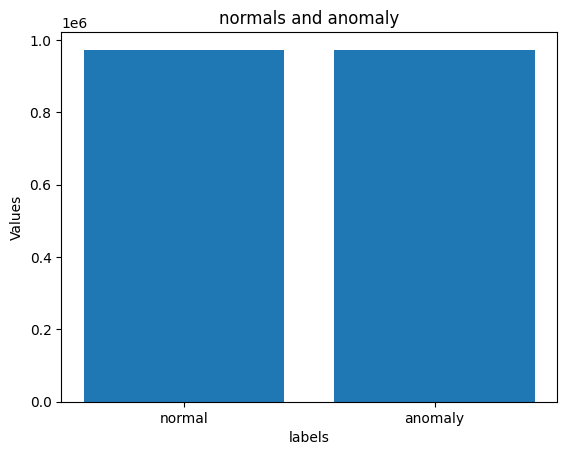

In [ ]:
labels = ["normal", "anomaly"]
values = [len(df[df["Label"]==1]), len(df[df["Label"]==0])]
plt.bar(labels, values)
plt.xlabel('labels')
plt.ylabel('Values')
plt.title("normals and anomaly")
plt.show()

In [ ]:
# /content/drive/MyDrive/KDD
df.to_csv("/content/drive/MyDrive/KDD/preKDD.csv", index=False)

# Naive bayes

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/KDD/preKDD.csv")

In [ ]:
label = df["Label"]
df = df.drop("Label", axis=1)

In [ ]:
scaler = StandardScaler()
df = scaler.fit_transform(df)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df, label, test_size=0.2, random_state=42)

In [ ]:
from sklearn.naive_bayes import GaussianNB

naive_bayes_classifier = GaussianNB()
naive_bayes_classifier.fit(X_train, y_train)

GaussianNB()

In [ ]:
y_pred = naive_bayes_classifier.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.970448173152786


In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[194335     98]
 [ 11401 183279]]


In [ ]:
# Calculate precision
precision = precision_score(y_test, y_pred)

# Calculate recall
recall = recall_score(y_test, y_pred)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)


print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))

Precision: 0.9995
Recall: 0.9414
F1 Score: 0.9696


# LSTM

In [ ]:
n_hidden_units = 50
n_epochs = 1
batch_size = 32

In [ ]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [ ]:
model = Sequential()
model.add(LSTM(n_hidden_units, input_shape=(1, 119)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
hist = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_data=(X_test, y_test))

48640/48640 [==============================] - 223s 5ms/step - loss: 0.0027 - accuracy: 0.9993 - val_loss: 0.0012 - val_accuracy: 0.9997


In [ ]:
predictions = model.predict(X_test)

12160/12160 [==============================] - 25s 2ms/step


In [ ]:
predictions = (predictions > 0.6).astype(np.int32)

# Calculate precision
precision = precision_score(y_test, predictions)

# Calculate recall
recall = recall_score(y_test, predictions)

# Calculate F1 score
f1 = f1_score(y_test, predictions)


print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))

Precision: 0.9997
Recall: 0.9994
F1 Score: 0.9996


In [ ]:
conf_matrix = confusion_matrix(y_test, predictions)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[194384     49]
 [   114 194566]]
